In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import string

from nltk.corpus import stopwords
from nltk.stem.lancaster import LancasterStemmer

from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [3]:
data= pd.read_csv('train.csv')
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
print(data.shape)

(159571, 8)


In [6]:
print('Data columns\n', data.columns)

Data columns
 Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')


In [7]:
print('First comment:\t',data['comment_text'][0])
print('Second comment:\t',data['comment_text'][1])

First comment:	 Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
Second comment:	 D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)


In [8]:
data['toxic'].value_counts(normalize= True) # around 10% of the data is toxic

0    0.904156
1    0.095844
Name: toxic, dtype: float64

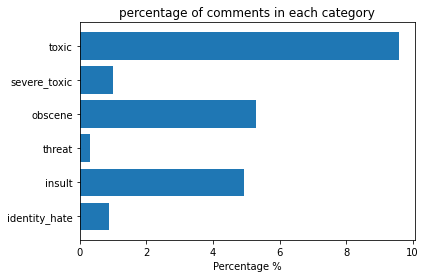

In [9]:
#% of comments of different categories
ind= np.arange(6)
n_rows= len(data)
data_count= data.iloc[:, 2:].sum()/ n_rows*100
ax= plt.barh(ind, [data_count[0], data_count[1], data_count[2], data_count[3], data_count[4], data_count[5]])
plt.xlabel('Percentage %')
plt.title('percentage of comments in each category')
plt.yticks(ind, ('toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate'))
plt.gca().invert_yaxis()
plt.show()

In [10]:
alphanumeric= lambda x: re.sub('\w*\d\w', ' ', x)
punc_lower= lambda x: re.sub('[%s]'% re.escape(string.punctuation), ' ', x.lower())
remove_n= lambda x: re.sub('\n', ' ', x)
remove_non_ascii= lambda x: re.sub(r'[^\x00-\x7f]', r'', x)

data['comment_text']= data['comment_text'].map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii)
data['comment_text'][0]

'explanation why the edits made under my username hardcore metallica fan were reverted  they weren t vandalisms  just closure on some gas after i voted at new york dolls fac  and please don t remove the template from the talk page since i m retired now        '

In [11]:
data_tox= data.loc[:, ['id', 'comment_text', 'toxic']]
data_sev= data.loc[:, ['id', 'comment_text', 'severe_toxic']]
data_obs= data.loc[:, ['id', 'comment_text', 'obscene']]
data_thr= data.loc[:, ['id', 'comment_text', 'threat']]
data_ins= data.loc[:, ['id', 'comment_text', 'insult']]
data_idh= data.loc[:, ['id', 'comment_text', 'identity_hate']]

In [12]:
data_tox['comment_text'][0]

'explanation why the edits made under my username hardcore metallica fan were reverted  they weren t vandalisms  just closure on some gas after i voted at new york dolls fac  and please don t remove the template from the talk page since i m retired now        '

In [13]:
data['comment_text'][1]

'd aww  he matches this background colour i m seemingly stuck with  thanks    talk       january       utc '

In [14]:
def working_data(data, label):
    data_1= data[data[label]== 1]
    length= len(data_1)
    data_0= data[data[label]== 0].iloc[:length, :]

    return pd.concat([data_0, data_1], axis= 0) 

In [15]:
data_types= [data_tox, data_sev, data_obs, data_thr, data_ins, data_idh]
labels= ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']
for i in range(len(labels)):
    data_types[i]= working_data(data_types[i], labels[i])

In [16]:
print('Number of zero class:', (data_types[0]['toxic']== 0).sum())
print('Number of 1 class:', (data_types[0]['toxic']== 1).sum())

Number of zero class: 15294
Number of 1 class: 15294


In [17]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import f1_score, precision_recall_curve, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

In [18]:
def cv_tf_train_test(df, label, vectorizer, n_gram):

    X= df['comment_text']
    y= df[label]

    X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.3, random_state= 42)

    cv1= vectorizer(ngram_range= (n_gram), stop_words= 'english')

    X_train_cv1= cv1.fit_transform(X_train)
    X_test_cv1= cv1.transform(X_test)

    lr= LogisticRegression()
    lr.fit(X_train_cv1, y_train)
    print('lr done')

    knn= KNeighborsClassifier()
    knn.fit(X_train_cv1, y_train)
    print('knn done')

    bnb= BernoulliNB()
    bnb.fit(X_train_cv1, y_train)
    print('bnb done')

    mnb= MultinomialNB()
    mnb.fit(X_train_cv1, y_train)
    print('gnb done')

    svc= LinearSVC()
    svc.fit(X_train_cv1, y_train)
    print('svc done')

    randomforest= RandomForestClassifier()
    randomforest.fit(X_train_cv1, y_train)
    print('random forest done')

    f1_score_data= {'F1 Score':[f1_score(lr.predict(X_test_cv1), y_test),
                                f1_score(knn.predict(X_test_cv1), y_test),
                                f1_score(bnb.predict(X_test_cv1), y_test),
                                f1_score(mnb.predict(X_test_cv1), y_test),
                                f1_score(svc.predict(X_test_cv1), y_test),
                                f1_score(randomforest.predict(X_test_cv1), y_test)]}

    score_df= pd.DataFrame(f1_score_data, index= ['logistics regression', 'knn', 'BaayesNB', 'MultinomialNB', 'LinearSVC', 'RandomForest'])

    return score_df

In [19]:
import time
t0= time.time()
df_tox_cv= cv_tf_train_test(data_types[0], 'toxic', TfidfVectorizer, (1, 1))
t1= time.time()

print('Total time taken:', t1- t0)

lr done
knn done
bnb done
gnb done
svc done
random forest done
Total time taken: 149.03304934501648


In [20]:
t0= time.time()
df_sev_cv= cv_tf_train_test(data_types[1], 'severe_toxic', TfidfVectorizer, (1, 1))
t1= time.time()

print('Total time taken:', t1- t0)

lr done
knn done
bnb done
gnb done
svc done
random forest done
Total time taken: 10.494617462158203


In [21]:
t0= time.time()
df_obs_cv= cv_tf_train_test(data_types[2], 'obscene', TfidfVectorizer, (1, 1))
t1= time.time()

print('Total time taken:', t1- t0)

lr done
knn done
bnb done
gnb done
svc done
random forest done
Total time taken: 38.98901033401489


In [22]:
t0= time.time() # 'threat','insult', 'identity_hate'
df_thr_cv= cv_tf_train_test(data_types[3], 'threat', TfidfVectorizer, (1, 1))

t1= time.time()
print('Total time taken:', t1- t0)

lr done
knn done
bnb done
gnb done
svc done
random forest done
Total time taken: 1.0282785892486572


In [23]:
t0= time.time()
df_ins_cv= cv_tf_train_test(data_types[4], 'insult', TfidfVectorizer, (1, 1))
t1= time.time()

print('Total time taken:', t1- t0)


lr done
knn done
bnb done
gnb done
svc done
random forest done
Total time taken: 43.81292533874512


In [24]:
t0= time.time()
df_idh_cv= cv_tf_train_test(data_types[5], 'identity_hate', TfidfVectorizer, (1, 1))

t1= time.time()

print('Total time taken:', t1- t0)


lr done
knn done
bnb done
gnb done
svc done
random forest done
Total time taken: 3.0481412410736084


In [25]:
df_tox_cv.rename(columns= {'F1 Score': 'F1_Score(Toxic)'}, inplace= True)
df_sev_cv.rename(columns= {'F1 Score': 'F1_Score(severe_toxic )'}, inplace= True)
df_obs_cv.rename(columns= {'F1 Score': 'F1_Score(obscene)'}, inplace= True)
df_thr_cv.rename(columns= {'F1 Score': 'F1_Score(threat)'}, inplace= True)
df_idh_cv.rename(columns= {'F1 Score': 'F1_Score(Identity_hate)'}, inplace= True)
df_ins_cv.rename(columns= {'F1 Score': 'F1_Score(insult)'}, inplace= True)

In [26]:
Result_df= pd.concat([df_tox_cv, df_sev_cv, df_obs_cv, df_thr_cv, df_ins_cv, df_idh_cv], axis= 1)
Result_df

,F1_Score(Toxic),F1_Score(severe_toxic ),F1_Score(obscene),F1_Score(threat),F1_Score(insult),F1_Score(Identity_hate)
logistics regression,0.883631,0.930886,0.918546,0.897527,0.901987,0.886420
knn,0.498107,0.882989,0.442404,0.834483,0.326688,0.781836
BaayesNB,0.764041,0.790541,0.781800,0.781421,0.779774,0.789981
MultinomialNB,0.873308,0.923541,0.902531,0.921053,0.895453,0.909091
LinearSVC,0.886505,0.934899,0.932235,0.883392,0.912940,0.900966
RandomForest,0.852182,0.936763,0.912281,0.902778,0.892602,0.878220


Obserev from the above table that the best performing algorithms are Random forest, Linear SVC and Logistics Regression atleast in validation set. Since Logostics Regression is a very simple model we would like to keep Linear SVC over RF and LR.

In [27]:
Result_df_tr= Result_df.transpose()

In [28]:
Result_df_tr

,logistics regression,knn,BaayesNB,MultinomialNB,LinearSVC,RandomForest
F1_Score(Toxic),0.883631,0.498107,0.764041,0.873308,0.886505,0.852182
F1_Score(severe_toxic ),0.930886,0.882989,0.790541,0.923541,0.934899,0.936763
F1_Score(obscene),0.918546,0.442404,0.781800,0.902531,0.932235,0.912281
F1_Score(threat),0.897527,0.834483,0.781421,0.921053,0.883392,0.902778
F1_Score(insult),0.901987,0.326688,0.779774,0.895453,0.912940,0.892602
F1_Score(Identity_hate),0.886420,0.781836,0.789981,0.909091,0.900966,0.878220


Text(0.5, 1.0, 'F1 score of Ml models used')

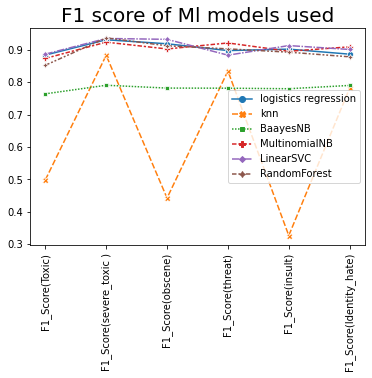

In [29]:
sns.lineplot(data= Result_df_tr, markers= True)
plt.xticks(rotation= '90', fontsize= 10)
plt.yticks(fontsize= 10)
plt.legend(loc= 'best')
plt.title('F1 score of Ml models used', fontsize= 20)

In [30]:
tfvectorizer= TfidfVectorizer(ngram_range= (1,1), stop_words= 'english')
X_tox= data_types[0].comment_text
y_tox= data_types[0].toxic
vec_tox= tfvectorizer.fit_transform(X_tox)

In [31]:
vec_tox.shape

(30588, 58887)

In [48]:
svc= LinearSVC()
svc.fit(vec_tox, y_tox)

LinearSVC()

In [54]:
# The following comments are just for checking the models decision function. Using abusive language is not intentional
sample1= ['Hey your shoes are ugly']
sample2= ['Hey your shoes are ugly stupid']
sample3= ['Hey your shoes are ugly moron']
sample4= ['You are so sweet']
sample5= ['Fuck you nigger']

sample1_vect= tfvectorizer.transform(sample1)
sample2_vect= tfvectorizer.transform(sample2)
sample3_vect= tfvectorizer.transform(sample3)
sample4_vect= tfvectorizer.transform(sample4)
sample5_vect= tfvectorizer.transform(sample5)


In [55]:
print(f'Toxicity of sample 1: {svc._predict_proba_lr(sample1_vect)[0][1]}')
print(f'Toxicity of sample 2: {svc._predict_proba_lr(sample2_vect)[0][1]}')
print(f'Toxicity of sample 3: {svc._predict_proba_lr(sample3_vect)[0][1]}')
print(f'Toxicity of sample 3: {svc._predict_proba_lr(sample4_vect)[0][1]}')
print(f'Toxicity of sample 3: {svc._predict_proba_lr(sample5_vect)[0][1]}')

Toxicity of sample 1: 0.7230125333001379
Toxicity of sample 2: 0.9563103768512319
Toxicity of sample 3: 0.9121967178284508
Toxicity of sample 3: 0.44555143708449496
Toxicity of sample 3: 0.9986575161569962


In [56]:
import pickle

In [59]:
def pickling(df, label):
    X= df['comment_text']
    y= df[label]

    tf_vectorizer= TfidfVectorizer()
    X_vect= tf_vectorizer.fit_transform(X)

    with open(r'{}.pkl'.format(label+'_vect'), 'wb') as f:
        pickle.dump(tf_vectorizer, f)

    svc= LinearSVC()
    svc.fit(X_vect, y)

    with open(r'{}.pkl'.format(label+ '_model'), 'wb') as f:
        pickle.dump(svc, f)

In [60]:
for i,j in zip(data_types,labels):
    pickling(i, j)